<a href="https://colab.research.google.com/github/D-Agar/imlo_courework/blob/master/Coursework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intelligent Systems - Individual Project Assessment
I aim to split the code into 3 sections:
1. Generating and analysing the datset
2. Developing my classification model
3. Training my model

In [183]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import v2, Lambda
import torchvision
from torch.nn import functional as F
from scipy import io as sio

# torch.manual_seed(30)
torch.cuda.empty_cache()

In [184]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if (torch.cuda.is_available()):
  print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
Tesla T4


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datase

In [185]:
# We perform random transformations to better generalise the training dataset
img_size = (224, 224)
train_transform = transforms.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=img_size, antialias=True, scale=(0.6, 1)),
    v2.AutoAugment(),
    # v2.Resize((100, 100)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.2),
    # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    v2.RandomRotation(20),
    v2.ToDtype(torch.float32, scale=True),
    # These are the values I have calculated
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    v2.ToImage(),
    v2.Resize(img_size),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    v2.ToImage(),
    v2.Resize(img_size),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Downloading and splitting the dataset

In [186]:
# I will download the data from PyTorch's website and use the appropriate data loader
# I am creating multiple training datasets to concatenate them together to create a larger training dataset
train_dataset1 = datasets.Flowers102(
    root='',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)
train_dataset2 = datasets.Flowers102(
    root='',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)
train_dataset3 = datasets.Flowers102(
    root='',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)
train_dataset4 = datasets.Flowers102(
    root='',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)
train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2, train_dataset3, train_dataset4])

valid_dataset = datasets.Flowers102(
    root='',
    split="val",
    download=True,
    transform=valid_transform
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = datasets.Flowers102(
    root='',
    split="test",
    download=True,
    transform=test_transform
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# Get the targets and ids
image_labels = sio.loadmat("flowers-102/imagelabels")
setids = sio.loadmat("flowers-102/setid")
image_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

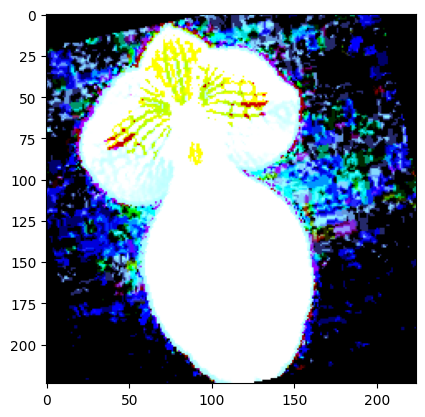

In [187]:
image, label = train_dataset1[12]
plt.imshow(image.cpu().permute(1,2,0))

Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 0
Device tensor is stored on: cuda:0


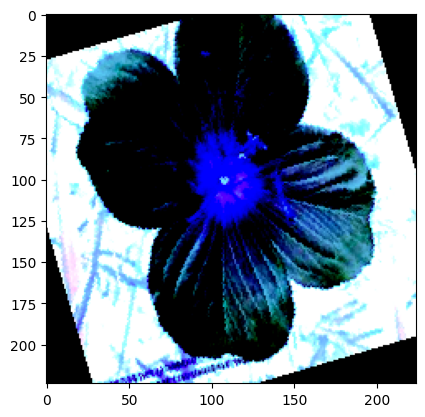

In [188]:
# look at the first training sample
image, label = train_dataset1[1]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.cpu().permute(1, 2, 0))

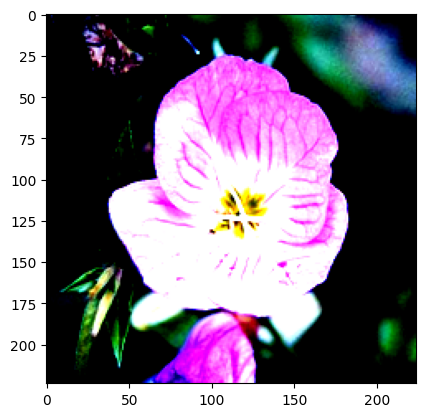

In [189]:
image2, label = test_dataset[0]
plt.imshow(image2.cpu().permute(1, 2, 0))

## Model

### Model 1a

In [190]:
class MyNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 4096),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(4096, 102)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(X)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.classifier(x)
        return x

### Model 1b

In [191]:
class MyNN1b(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*14*14, 4096),
            nn.LeakyReLU(),
        )

        self.classifier = nn.Linear(4096, 102)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.classifier(x)
        return x

### Model 1c

In [192]:
class MyNN1c(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1024),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.classifier(x)
        return x

### Model 1d

In [193]:
class MyNN1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(128*14*14, 4096),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(4096, 102)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.classifier(x)
        return x

### Model 2

In [194]:
class MyNN2(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*14*14, 4096),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )

        self.fc3 = nn.Linear(4096, 102)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

### Model 3

In [195]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()

        # Bias is removed during these convolutional layers due to Batch Normalisation being present
        self.layer1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [196]:
class MyNN3(nn.Module):
    def __init__(self):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.inplanes),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layer1 = self.layer(ResidualBlock, 64, 3)
        self.drop1 = nn.Dropout(0.5)
        self.layer2 = self.layer(ResidualBlock, 128, 4, stride=2)
        self.drop2 = nn.Dropout(0.5)
        self.layer3 = self.layer(ResidualBlock, 256, 6, stride=2)
        self.drop3 = nn.Dropout(0.5)
        self.layer4 = self.layer(ResidualBlock, 512, 3, stride=2)
        self.drop4 = nn.Dropout(0.5)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 102)

        for m in self.modules():
            # He initialization for Convolutional layers, preventing exploding gradient
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            # Weights = 0, Biases = 1, making it initially performs an identity transformation
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.drop1(x)
        x = self.layer2(x)
        x = self.drop2(x)
        x = self.layer3(x)
        x = self.drop3(x)
        x = self.layer4(x)
        x = self.drop4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

### Choosing the Model

In [197]:
model = MyNN1c()
# model = torchvision.models.vgg11_bn()
model.to(device)

MyNN1c(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm

## Training

### Loss Function

In [198]:
# Targets don't have to be one-hot encoded
# Model output (criterion input) is expected to contain un-normalised inputs
criterion = nn.CrossEntropyLoss()

### Optimiser

In [199]:
# Momentum pushes the optimiser towards the strongest gradient over multiple steps.
# optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0004)
optimiser = optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser, patience=5)

### Dataloaders

In [200]:
batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))
train_loader = DataLoader(train_dataset1, batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))

In [201]:
valid_loader = DataLoader(valid_dataset, batch_size, num_workers=0, generator=torch.Generator(device=device))

### Full training of model

In [202]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(dataloader.dataset)
    correct /= size
    print(f"Training Set: Loss: {train_loss:>8f}, Accuracy: {(100*correct):>0.1f}%")
    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Validation Set: Loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")
    return test_loss, correct

### Model Loop

In [203]:
# epochs = 20
# PATH = 'model5.pth'

# train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimiser, train_loader, valid_loader, PATH, epochs)

In [204]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_acc = 0.
best_loss = 100
epochs = 50
# Early stopping
patience = 5
early_stop_counter = 0
path = 'model1_30_64_0001.pth'
# model.load_state_dict(torch.load(path))
for e in range(epochs):
    print(f"Epoch [{e+1}/{epochs}]")
    train_loss, train_acc = train_loop(train_loader, model, criterion, optimiser)
    val_loss, val_acc = test_loop(valid_loader, model, criterion)

    lr_scheduler.step(val_loss)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), path)
        best_loss = val_loss
        early_stop_counter = 0
    if val_loss > best_loss:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Stopping early")
            break

Epoch [1/50]
Training Set: Loss: 4.727424, Accuracy: 1.4%
Validation Set: Loss: 4.630023, Accuracy: 1.0% 

Epoch [2/50]
Training Set: Loss: 4.405638, Accuracy: 4.7%
Validation Set: Loss: 4.331788, Accuracy: 5.8% 

Epoch [3/50]
Training Set: Loss: 4.146495, Accuracy: 7.2%
Validation Set: Loss: 3.844384, Accuracy: 10.7% 

Epoch [4/50]
Training Set: Loss: 3.963053, Accuracy: 9.4%
Validation Set: Loss: 3.578181, Accuracy: 16.0% 

Epoch [5/50]
Training Set: Loss: 3.725482, Accuracy: 14.9%
Validation Set: Loss: 3.398656, Accuracy: 17.6% 

Epoch [6/50]
Training Set: Loss: 3.610264, Accuracy: 16.1%
Validation Set: Loss: 3.243732, Accuracy: 22.5% 

Epoch [7/50]
Training Set: Loss: 3.479638, Accuracy: 18.6%
Validation Set: Loss: 3.121723, Accuracy: 24.7% 

Epoch [8/50]
Training Set: Loss: 3.263607, Accuracy: 19.8%
Validation Set: Loss: 3.017306, Accuracy: 26.1% 

Epoch [9/50]
Training Set: Loss: 3.198891, Accuracy: 23.4%
Validation Set: Loss: 2.932118, Accuracy: 28.9% 

Epoch [10/50]
Training Se

### Save Model

In [205]:
# torch.save(model.state_dict(), path)

### Visualisation

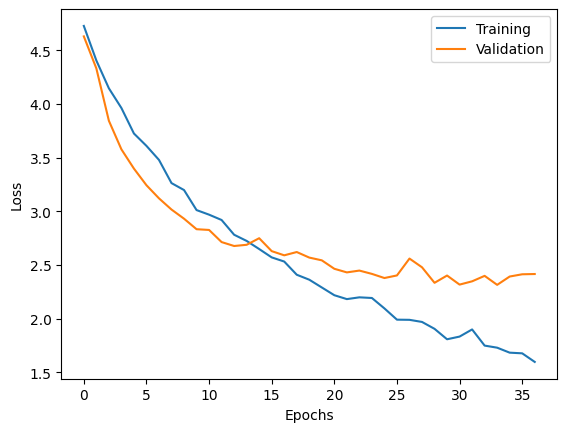

In [206]:
# Visualise the losses
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

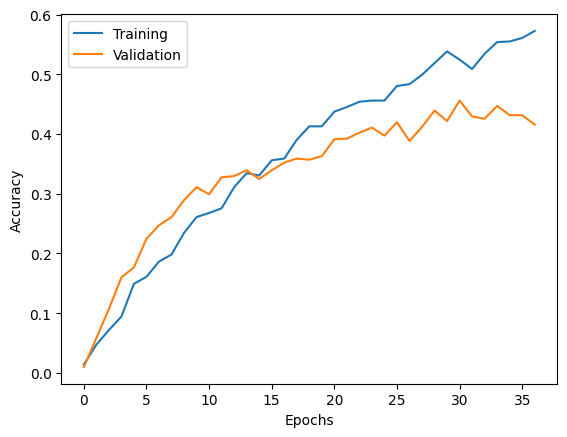

In [207]:
# Visualise the accuracy
plt.plot(train_accuracies, label='Training')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [208]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/'+path)
model.load_state_dict(torch.load(path))
images, labels = next(iter(valid_loader))
writer.add_graph(model, images)
writer.close()

## Testing

In [209]:
# Test on test dataset
test_loader = DataLoader(test_dataset, batch_size, num_workers=0, generator=torch.Generator(device=device))

In [210]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(test_loader):
            X = data[0].to(device)
            y = data[1].to(device)

            predicted = model(X)

            # Check each image's prediction
            acc += (predicted.argmax(dim=1) == y).sum().item()
    model.train()
    return acc/len(test_loader.dataset)

In [211]:
test_model = MyNN1c().to(device)
test_model.load_state_dict(torch.load(path))
test_acc = test(test_model, test_loader)

In [212]:
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 39.01%
